# Deep Learning Optimization

#### Goal of This File:

##### 1. Import Libraries and Helper Functions ==> Data Sourcing and Munging ==> Utility Functions ==> Data Preparation and Pre-Processing

##### 2. Confirm Findings From ML File ==> Sklearn Embeddings vs Gensim Embeddings ==> Sentiment Polarity Final Score ==> 3 labels vs 5 labels

##### 3. XGBoost

##### 4. Simple RNN

##### 5. LSTM ==> Bidirectional LSTM

##### 6. Sequence-to-Vector Transformers

##### 7. Conclusion

## 1. Import Libraries, Helper Functions and Load Constants

In [33]:
!pip install pandas numpy nltk scikit-learn wordcloud seaborn gensim tensorflow imblearn xgboost matplotlib > /dev/null


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
TF_ENABLE_ONEDNN_OPTS=0
URLS = CHUNKS_URLS
LIMIT = 60
BASE_FILE_NAME = "chunk_"
ACTUAL_DATA_SHAPE = 6990280
RANDOM_STATE = 42

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [4]:
def get_chunks(urls,limit=0,verbose = 1,base_name = ""):
    #downloads all data from their urls
    for i,url in enumerate(urls):
        if limit:
            if i == limit - 1:
                return
        file_name = base_name + str(i + 1)
        #checks if file already exists
        if os.path.exists(file_name):
            print(f"{file_name} already exists.")
            continue
        r = requests.get(url)
        if i % verbose == 0:
            print(f"Downloading {file_name}...")
        with open(file_name, 'wb') as fd:
            for chunk in r.iter_content():
                #save file in the current directory of the notebook
                fd.write(chunk)

In [5]:
def get_all_file_names(base_name,limit_num):
    return [base_name + str(num) for num in range(1,limit_num + 1)]

In [6]:
def read_chunks(files):
    #reads chunks csvs and converts them to a dataframe format
    final_df = []
    for file in files:
        df = pd.read_csv(file)
        final_df.append(df)
        #function returns a list of dfs, or one df if only one input is given
    return final_df

In [7]:
def group_up_chunks(dfs):
    #adds up all dataframes together
    return pd.concat(dfs)

In [8]:
def check_no_missing_data(shape_loaded,shape_actual):
    actual_shape_loaded = (shape_loaded / shape_actual) * 100
    return actual_shape_loaded

#### 1.1.2 Loading The Data

In [9]:
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.
chunk_7 already exists.
chunk_8 already exists.
chunk_9 already exists.
chunk_10 already exists.
chunk_11 already exists.
chunk_12 already exists.
chunk_13 already exists.
chunk_14 already exists.
chunk_15 already exists.
chunk_16 already exists.
chunk_17 already exists.
chunk_18 already exists.
chunk_19 already exists.
chunk_20 already exists.
chunk_21 already exists.
chunk_22 already exists.
chunk_23 already exists.
chunk_24 already exists.
chunk_25 already exists.
chunk_26 already exists.
chunk_27 already exists.
chunk_28 already exists.
chunk_29 already exists.
chunk_30 already exists.
chunk_31 already exists.
chunk_32 already exists.
chunk_33 already exists.
chunk_34 already exists.
chunk_35 already exists.
chunk_36 already exists.
chunk_37 already exists.
chunk_38 already exists.
chunk_39 already exists.
chunk_40 already exists.
chunk_41 

#### 1.1.3 Merging all Individual Files

In [10]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [11]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names)

In [12]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [13]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [14]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [15]:
review_data = df[['text', 'stars']].copy()

In [16]:
review_data

,text,stars
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...
116480,Latest addition to services from ICCU is Apple...,5.0
116481,"This spot offers a great, affordable east week...",5.0
116482,This Home Depot won me over when I needed to g...,4.0
116483,For when I'm feeling like ignoring my calorie-...,5.0


In [17]:
review_data.reset_index()

,index,text,stars
0,0,"If you decide to eat here, just be aware it is...",3.0
1,1,I've taken a lot of spin classes over the year...,5.0
2,2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...,...
6990275,116480,Latest addition to services from ICCU is Apple...,5.0
6990276,116481,"This spot offers a great, affordable east week...",5.0
6990277,116482,This Home Depot won me over when I needed to g...,4.0
6990278,116483,For when I'm feeling like ignoring my calorie-...,5.0


In [18]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [ ]:
review_data.drop(df['index'],inplace = True)

### 1.2 Data Preparation and Pre-processing

In [ ]:
preprocessed_text = [process_corpus(remove_stop_words(text)) for text in review_data['full_review_text']]
review_data_preprocessed = df[['preprocessed_text', 'stars']].copy()

In [ ]:
file = open('review_data_preprocessed', 'wb')
pickle.dump(review_data_preprocessed, file)
file.close()

In [20]:
X = review_data_preprocessed['full_review_text']
y = review_data_preprocessed['star_rating']

In [ ]:
# Train word2vec model using sklearn
count_model = CountVectorizer()
word2vec_model_sklearn = count_model.fit_transform([' '.join(text) for text in X])
svd_model = TruncatedSVD(n_components=100, random_state=42)
svd_model_sklearn = svd_model.fit_transform(X)
word_vectors_sklearn = dict(zip(count_model.get_feature_names(), svd_model.components_.transpose()))

In [ ]:
# Train word2vec model using gensim
word2vec_model_gensim = Word2Vec(X, min_count=1, size=100)

In [ ]:
# Compare the two models
word1 = 'this is a sentence'
word2 = 'this is another another sentence'

In [ ]:
# Cosine similarity using scikit-learn model
vec1_sklearn = word_vectors_sklearn[word1]
vec2_sklearn = word_vectors_sklearn[word2]
similarity_sklearn = np.dot(vec1_sklearn, vec2_sklearn) / (np.linalg.norm(vec1_sklearn) * np.linalg.norm(vec2_sklearn))
print(f"Similarity between '{word1}' and '{word2}' using scikit-learn model: {similarity_sklearn:.4f}")

# Cosine similarity using gensim model
similarity_gensim = word2vec_model_gensim.wv.similarity(word1, word2)
print(f"Similarity between '{word1}' and '{word2}' using gensim model: {similarity_gensim:.4f}")

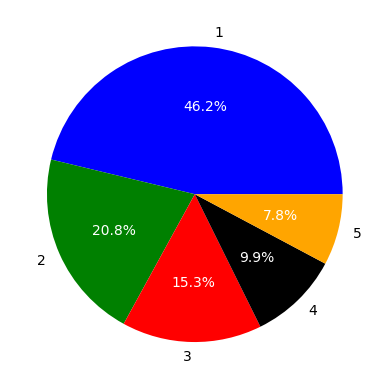

In [21]:
visualize_ratings_pie(y,1,5)

In [26]:
smote_resampler = SMOTE(random_state = RANDOM_STATE)
smote_x,smote_y = smote_resampler.fit_resample(X,y)

ValueError: could not convert string to float: "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."